In [4]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".7"
import jax.numpy as jnp
from jax.nn import log_softmax,one_hot
from jax.lax import dynamic_slice,dynamic_slice_in_dim
from jax.lax import dynamic_update_slice
from jax import grad,vmap
from jax import random
import jax
import pandas as pd
import numpy as np
import gc
#jax.config.update("jax_enable_x64", True)
from scipy.sparse import csc_matrix
import sksparse
import scipy.sparse as sp
from jax.experimental import sparse

In [5]:
df=pd.read_csv("premier_league.csv")
week=jnp.asarray((pd.to_datetime(df.Date,dayfirst=True)-pd.to_datetime("19/08/2000",dayfirst=True)).dt.days//7,dtype=int)
week=jnp.concat([week, week])
weeks=jnp.max(week)+1
G=len(df)
attacker=jnp.concat([jnp.asarray(df.HomeTeam.astype('category').cat.codes,dtype=int),jnp.asarray(df.AwayTeam.astype('category').cat.codes,dtype=int)])
defender=jnp.concat([jnp.asarray(df.AwayTeam.astype('category').cat.codes,dtype=int),jnp.asarray(df.HomeTeam.astype('category').cat.codes,dtype=int)])
playing_at_home=jnp.concat([jnp.ones(G,dtype=int),jnp.zeros(G,dtype=int)])
numteams=jnp.max(attacker)+1
ind_attack=jax.numpy.ravel_multi_index([attacker,week], [numteams,weeks])
ind_defense=jax.numpy.ravel_multi_index([defender,week], [numteams,weeks])
y=jnp.concat([jnp.asarray(df.FTHG,dtype=int),jnp.asarray(df.FTAG,dtype=int)])
nbeta=jnp.asarray(2*numteams*weeks,dtype="int32").item()

In [6]:
@jax.jit
def lpost(beta):
    numteams=43
    weeks=1041
    reg0=0.1
    reg=100

    J=reg0/2*jnp.sum(beta**2)
    attack=dynamic_slice(beta,(0,),(numteams*weeks,))
    defense=dynamic_slice(beta,(numteams*weeks,),(numteams*weeks,))#beta[(numteams*weeks):(2*numteams*weeks)]
    attack_r=jnp.reshape(attack,[numteams,weeks])
    defense_r=jnp.reshape(defense,[numteams,weeks])
    J=J+reg/2*(jnp.sum((attack_r[:,1:weeks]-attack_r[:,0:(weeks-1)])**2)+jnp.sum((defense_r[:,1:weeks]-defense_r[:,0:(weeks-1)])**2))

    xvar=attack[ind_attack]+defense[ind_defense]
    lam=jax.nn.softplus(xvar)
    J=J+jnp.sum(-y*jnp.log(lam)+lam)
    return J
grad_lpost=jax.jit(grad(lpost))
vmap_grad_lpost=jax.jit(vmap(grad(lpost)))

import scipy.optimize
optim_res=scipy.optimize.minimize(lpost,jnp.zeros(nbeta),method="L-BFGS-B",jac=grad_lpost)
beta_min=jnp.asarray(optim_res.x).reshape([1,nbeta])

def hvp(x, v):
    return jax.grad(lambda x: jnp.vdot(grad_lpost(x), v))(x)
def hvp_beta_min(v):
    return hvp(beta_min.reshape([nbeta,]), v)
vhvp_beta_min=vmap(jax.jit(hvp_beta_min))

data = jnp.array([], dtype=jnp.float32) # Or any desired dtype
indices = jnp.array([], dtype=jnp.int32).reshape(0, 2)
zero_bcoo_array = sparse.BCOO((data, indices), shape=[nbeta,nbeta])

ID=sparse.eye(nbeta)

hess_min=zero_bcoo_array
hess_min_sp=sp.csc_matrix((nbeta,nbeta),dtype=float)
vmap_size=5000

for it in range(nbeta//vmap_size):
    slice1=sparse.todense(ID[(it*vmap_size):((it+1)*vmap_size),:])
    hess1=vhvp_beta_min(slice1)
    hess_update=sparse.bcoo_concatenate([sparse.BCOO((data, indices), shape=[it*vmap_size,nbeta]), sparse.BCOO.fromdense(hess1),sparse.BCOO((data, indices), shape=[nbeta-(it+1)*vmap_size,nbeta])],dimension=0)
    #if(it>0):
    hess_update_sp=sp.vstack((sp.csc_matrix((it*vmap_size,nbeta),dtype=float),sp.csc_matrix(hess1),sp.csc_matrix((nbeta-(it+1)*vmap_size,nbeta))),dtype=float)
    # else:
    #     hess_update_sp=sp.vstack(sp.csc_matrix(hess1),sp.csc_matrix((nbeta-(it+1)*vmap_size,nbeta),dtype=float))
    hess_min+=hess_update
    hess_min_sp+=hess_update_sp

slice1=sparse.todense(ID[((nbeta//vmap_size)*vmap_size):nbeta,:])
hess1=vhvp_beta_min(slice1)
hess_update=sparse.bcoo_concatenate([sparse.BCOO((data, indices), shape=[(nbeta//vmap_size)*vmap_size,nbeta]), sparse.BCOO.fromdense(hess1)],dimension=0)
hess_update_sp=sp.vstack((sp.csc_matrix(((nbeta//vmap_size)*vmap_size,nbeta),dtype=float),sp.csc_matrix(hess1)),dtype=float)
hess_min+=hess_update
hess_min_sp+=hess_update_sp


In [7]:
#cholesky factorization
hess_min_sp=(hess_min_sp+hess_min_sp.T)/2
factor = sksparse.cholmod.cholesky(hess_min_sp,ordering_method="metis")
spL=sp.csr_matrix(factor.L())
Pordering=factor.P()
spID=sp.csr_matrix(sp.identity(nbeta))
spP=sp.csr_matrix(spID[Pordering,:].T)
#np.mean(np.abs(hess_min_sp-spP@spL@spL.T@spP.T)) #checking error

import cupy as cp
from cupy import cublas
from cupy.linalg import _util
from cupyx.scipy import sparse as cpsparse
from cupyx.scipy.sparse.linalg import _interface
from cupyx.scipy.sparse.linalg._iterative import _make_system


import cupy as cp
from cupyx.scipy.sparse import csr_matrix as cupy_csr_matrix
#import cupyx
import numpy as np
L_T_cupy=(cupy_csr_matrix((cp.asarray(spL.data,dtype="float32"),cp.asarray(spL.indices),cp.asarray(spL.indptr)))).T
P_cupy=(cupy_csr_matrix((cp.asarray(spP.data,dtype="float32"),cp.asarray(spP.indices),cp.asarray(spP.indptr))))

from jax.extend import core
from jax.interpreters import batching
from jax.interpreters import xla
#from jax.interpreters import xla

sparse_triangular_solve_p = core.Primitive("sparse_triangular_solve")

#@trace("sparse_triangular_solve")
def sparse_triangular_solve(b):
  """A JAX traceable sparse  triangular solve"""
  return sparse_triangular_solve_p.bind(b)

@sparse_triangular_solve_p.def_impl
def sparse_triangular_solve_impl(b):
    """The implementation of the sparse triangular solve. This is not JAX traceable."""
    #L = sp.csc_array((L_x, L_indices, L_indptr)) 
    b_cupy=cp.from_dlpack(b).T
    return jax.dlpack.from_dlpack(P_cupy@cpsparse.linalg.spsolve_triangular(L_T_cupy, b_cupy,lower=False)).T

@sparse_triangular_solve_p.def_abstract_eval
def sparse_triangular_solve_abstract_eval(*avals, **params):
  # avals contains the abstract values (e.g., ShapedArray) of the inputs
  # params contains any parameters passed during primitive binding

  # Basic validation (optional but recommended)
  if len(avals) != 1:
    raise ValueError("sparse_triangular_solve expects exactly one input operand.")

  input_aval = avals[0]

  # Check if the input is a ShapedArray (most common case)
  if not isinstance(input_aval, jax.core.ShapedArray):
      raise TypeError(f"Input must be a ShapedArray, got {type(input_aval)}")

  # Ensure dtype is floating-point for this specific operation
  if not jnp.issubdtype(input_aval.dtype, jnp.floating):
      # Or you might define specific promotion rules
      raise TypeError(f"Input dtype must be floating-point, got {input_aval.dtype}")

  # The core logic: Determine output shape and dtype
  # For 'custom_add_one', the shape and dtype are the same as the input.
  output_shape = input_aval.shape
  output_dtype = input_aval.dtype

  # Return the abstract value of the output
  return jax.core.ShapedArray(output_shape, output_dtype)


#@trace("sparse_triangular_solve_batch")
def sparse_triangular_solve_batch(vector_arg_values,batch_axis):
    b=vector_arg_values[0]
    if(b.ndim==3):
      return (sparse_triangular_solve(b.reshape([b.shape[0]*b.shape[1],b.shape[2]]))).reshape(b.shape), batch_axis[0]
    else:
      return sparse_triangular_solve(b), batch_axis[0]
    
batching.primitive_batchers[sparse_triangular_solve_p] = sparse_triangular_solve_batch

vmap_invcholHprodv=vmap(sparse_triangular_solve)

In [8]:
def spectral_norm_approx(mat_sp, num_iterations=2000, key=jax.random.PRNGKey(0)):
    shape = mat_sp.shape
    if len(shape) != 2:
        raise ValueError("Matrix must be 2D")
        
    m, n = shape
    # Use jax.random.normal for initial vector
    x = jax.random.normal(key, (n,), dtype=mat_sp.dtype)
    
    for _ in range(num_iterations):
        # Matrix-vector product with BCOO is supported
        Ax = mat_sp @ x
        AtAx = mat_sp.T @ Ax
        norm_sq = jnp.sum(AtAx * x) / jnp.sum(x * x) # Rayleigh quotient approximation of the largest eigenvalue of A^T A
        x = AtAx / jnp.linalg.norm(AtAx) # Normalize the vector
        
    # The largest singular value is the square root of the largest eigenvalue of A^T A
    return jnp.sqrt(norm_sq)

M=spectral_norm_approx(hess_min)
m=0.1
print("Max eigenvalue of Hessian at mode:", M)

Max eigenvalue of Hessian at mode: 400.67108


In [9]:
from methods.multilevel_ubu import multilevel_ubu,vmap_multilevel_ubu



r=4
c=1.0/16
beta_min=beta_min.reshape([1,nbeta])
maxlevel=8
max_parallel_chain=32
test_dim=nbeta


niter=2000
burnin=400
rep=64

h=jnp.array(1.5)/jnp.sqrt(M)
gam=jnp.sqrt(m)
key=random.key(170424)

@jax.jit
def test_function(x):
    return x

@jax.jit
def vmap_test_function(x):
    return x



In [ ]:
key=random.key(345632)
_=multilevel_ubu(niter,burnin,rep,h,gam, vmap_grad_lpost, vmap_test_function, r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, 3,key)


Lev: 0 / 1 xn/x2n error: 0.049823973
h: 0.07493717 h/2: 0.037468586
Lev: 1 / 2 xn/x2n error: 0.029851727
h: 0.037468586 h/2: 0.018734293
maxmultilevels: 5
multilevels: 3
Lev: 2 / 3 ...
hm: 0.018734293
Multi error: [9.4744666e-03 2.4083047e-03 6.0196640e-04 1.5047772e-04 2.7908203e-01
 0.0000000e+00]


In [ ]:
par_batch=16
key=random.key(345632)
par_runs=par_batch
subkey=random.split(key,par_runs)
res=vmap_multilevel_ubu(niter,burnin,rep,h,gam, vmap_grad_lpost, vmap_test_function, r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, subkey,par_batch)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 0.07493717 h/2: 0.037468586
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.037468586 h/2: 0.018734293
maxmultilevels: 5
multilevels: 0
Lev: 2 / 3 ...
hm: 0.018734293
Multi error: VmapTracer<float32[6]>


In [ ]:
import time

key=random.key(3459823)
par_runs=16*4
subkey=random.split(key,par_runs)
start_time=time.time()
res=vmap_multilevel_ubu(niter,burnin,rep,h,gam, vmap_grad_lpost, vmap_test_function, r,c,nbeta,test_dim,beta_min,maxlevel,max_parallel_chain, subkey,par_batch)
end_time=time.time()
total_time=end_time-start_time
print("Total time:", total_time)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2]
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 0.07493717 h/2: 0.037468586
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.037468586 h/2: 0.018734293
maxmultilevels: 5
multilevels: 0
Lev: 2 / 3 ...
hm: 0.018734293
Multi error: VmapTracer<float32[6]>
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 0.07493717 h/2: 0.037468586
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.037468586 h/2: 0.018734293
maxmultilevels: 5
multilevels: 0
Lev: 2 / 3 ...
hm: 0.018734293
Multi error: VmapTracer<float32[6]>
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 0.07493717 h/2: 0.037468586
Lev: 1 / 2 xn/x2n error: VmapTracer<float32[]>
h: 0.037468586 h/2: 0.018734293
maxmultilevels: 5
multilevels: 0
Lev: 2 / 3 ...
hm: 0.018734293
Multi error: VmapTracer<float32[6]>
Lev: 0 / 1 xn/x2n error: VmapTracer<float32[]>
h: 0.07493717 h/2: 0.037468586
Lev: 1 / 2 xn/x2n er

In [ ]:
from methods.process_res_multi import process_res_multi

ess,grad_per_ess=process_res_multi(res,jnp.arange(par_runs))
print("max grad per ess coordinates:",jnp.max(grad_per_ess[:nbeta]))
print("min ess coordinates:",jnp.min(ess[:nbeta]))
print("ess/sec for UBUBU coordinates:",jnp.min(ess[:nbeta])/(total_time/par_runs))

mean repruns: [6.4000e+01 4.0000e+00 1.0000e+00 1.0000e+00 3.1250e-02 1.5625e-02
 0.0000e+00 0.0000e+00 0.0000e+00]
test_mean_var: 1.1334458e-05
ngradtot: 257812.5
test_mean_lev_0_comp1: 0.8477511
max_test_mean_lev_0_var: 0.00010955678
test_squaremean_lev_0_comp1: 0.8516886
blockstart: [ 0 64 68 69 70 71 72 73 74]
blockend: [64 68 69 70 71 72 73 74 75]
maxlevel: 8
lev: 1
max_lev_test_mean_diff: 0.00016055506
max_lev_test_mean_diff_var: 4.1730597e-09 repruns[lev+1,0]: 4
lev: 2
max_lev_test_mean_diff: 3.357769e-05
max_lev_test_mean_diff_var: 1.2244485e-09 repruns[lev+1,0]: 1
lev: 3
max_mean_diff_lev: 1.12180915e-05
max_test_mean_var: 2.1139343e-10
test_post_var: 0.13394982
median test mean var: 3.3796034e-05
median test post var: 0.14149982
min test post var: 0.06842029
min_ess: 2271.0852
median_ess: 4160.7017
maxgradperess: 113.519516
mediangradperess: 61.963707
test_mean: 0.8476171
test_squaremean: 0.85240453
max grad per ess coordinates: 113.519516
min ess coordinates: 2271.0852
ess/s

In [18]:
from methods.bootstrap_res import bootstrap_res
bootstrap_samp=64
key=random.key(23847)
keys=random.split(key,bootstrap_samp)
grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2=bootstrap_res(res,bootstrap_samp,par_runs,None,process_res_multi,keys)

import pickle
with open('./output/Poisson_UBUBU.pkl', 'wb') as file:
    pickle.dump((ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2),file)

mean repruns: [6.400e+01 4.000e+00 1.000e+00 1.000e+00 6.250e-02 3.125e-02 0.000e+00
 0.000e+00 0.000e+00]
test_mean_var: 1.1058695e-05
ngradtot: 257812.5
test_mean_lev_0_comp1: 0.84856343
max_test_mean_lev_0_var: 0.00011197725
test_squaremean_lev_0_comp1: 0.85284615
blockstart: [ 0 64 68 69 70 71 72 73 74]
blockend: [64 68 69 70 71 72 73 74 75]
maxlevel: 8
lev: 1
max_lev_test_mean_diff: 0.00016500526
max_lev_test_mean_diff_var: 4.3217296e-09 repruns[lev+1,0]: 4
lev: 2
max_lev_test_mean_diff: 3.6343095e-05
max_lev_test_mean_diff_var: 1.6859043e-09 repruns[lev+1,0]: 1
lev: 3
max_mean_diff_lev: 1.2708207e-05
max_test_mean_var: 2.3061769e-10
test_post_var: 0.13372624
median test mean var: 3.3830118e-05
median test post var: 0.1414896
min test post var: 0.068344355
min_ess: 2214.6443
median_ess: 4157.3906
maxgradperess: 116.4126
mediangradperess: 62.013054
test_mean: 0.84842473
test_squaremean: 0.8535508
mean repruns: [6.400e+01 4.000e+00 1.000e+00 1.000e+00 3.125e-02 0.000e+00 0.000e+00
 

In [51]:
import pickle
with open('./output/Poisson_UBUBU.pkl', 'rb') as file:
    (ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2)=pickle.load(file)
print("Bootstrap sd for max grad per ess coordinates:", sdmax)

Bootstrap sd for max grad per ess coordinates: 1.4080366


<Figure size 640x480 with 0 Axes>

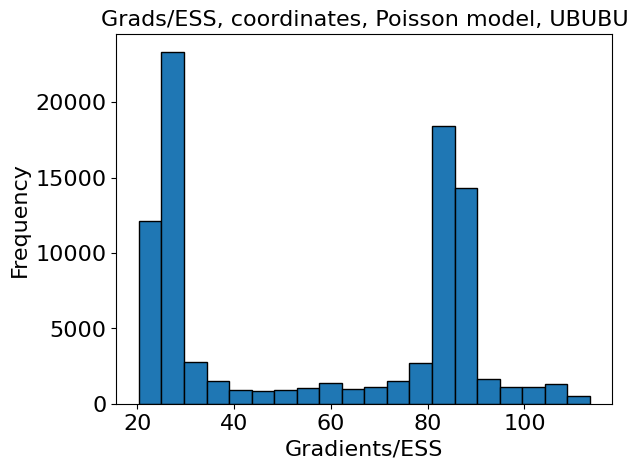

In [52]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Grads/ESS, coordinates, Poisson model, UBUBU",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(grad_per_ess[:nbeta],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/UBUBU_Poisson_coordinates.pdf", format="pdf",bbox_inches='tight')  
plt.show()

In [41]:
from methods.hmc import vmap_hmcsampler
from methods.process_res_hmc import process_res_hmc
niter=400
burnin=40
partial=0.7
numsteps=200#118
test_dim=nbeta
par_runs=256
h=jnp.array(0.15)/jnp.sqrt(M)
key=random.key(1233459)
keys=random.split(key,par_runs)

x0=jnp.ones([par_runs,1])@beta_min.reshape([1,nbeta])+vmap_invcholHprodv(random.normal(key,[par_runs,nbeta]))

chunk_size=32
res=vmap_hmcsampler(niter,burnin,numsteps,partial,h,lpost,grad_lpost,test_function,test_dim,x0[0:chunk_size,],keys[0:chunk_size],chunk_size)

In [43]:
import time
start_time=time.time()
res=vmap_hmcsampler(niter,burnin,numsteps,partial,h,lpost,grad_lpost,test_function,test_dim,x0,keys,chunk_size)
end_time=time.time()
total_time=end_time-start_time
print("Total time:", total_time)

Total time: 238.4876320362091


In [46]:
print("mean acceptance rate:", res[2].mean())
ess,grad_per_ess=process_res_hmc(res,jnp.arange(par_runs))

print("max grad per ess coordinates:",jnp.max(grad_per_ess[:nbeta]))
print("min ess coordinates:",jnp.min(ess[:nbeta]))
print("ess/sec for RHMC coordinates:",jnp.min(ess[:nbeta])/(total_time/par_runs))

mean acceptance rate: 0.71479046
max grad per ess coordinates: 1649.7424
min ess coordinates: 53.34166
ess/sec for RHMC coordinates: 57.25859


In [48]:
from methods.bootstrap_res import bootstrap_res
bootstrap_samp=256
key=random.key(23847)
keys=random.split(key,bootstrap_samp)
grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2=bootstrap_res(res,bootstrap_samp,par_runs,None,process_res_hmc,keys)
import pickle
with open("./output/Poisson_RHMC.pkl", "wb") as file:
    pickle.dump((ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2),file)

In [49]:
import pickle
with open("./output/Poisson_RHMC.pkl", "rb") as file:
    (ess, grad_per_ess,grad_per_ess_arr,max_grad_per_ess,max_grad_per_ess2,sd,sdmax,sdmax2)=pickle.load(file)
print("Bootstrap sd for max grad per ess coordinates:", sdmax)

Bootstrap sd for max grad per ess coordinates: 68.65974


<Figure size 640x480 with 0 Axes>

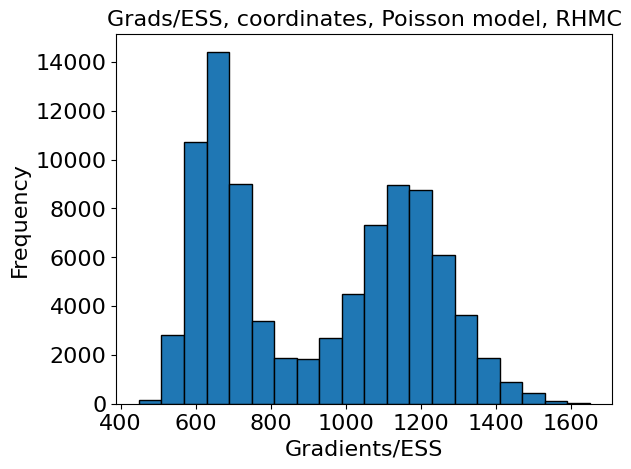

In [50]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
fig, ax = plt.subplots()
ax.set_xlabel("Gradients/ESS", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Grads/ESS, coordinates, Poisson model, RHMC",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hist(grad_per_ess[:nbeta],bins=20,histtype='bar',edgecolor='black')
plt.savefig("./output/RHMC_Poisson_coordinates.pdf", format="pdf",bbox_inches='tight')  
plt.show()